/opt/homebrew/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/fangyuanyu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


2565


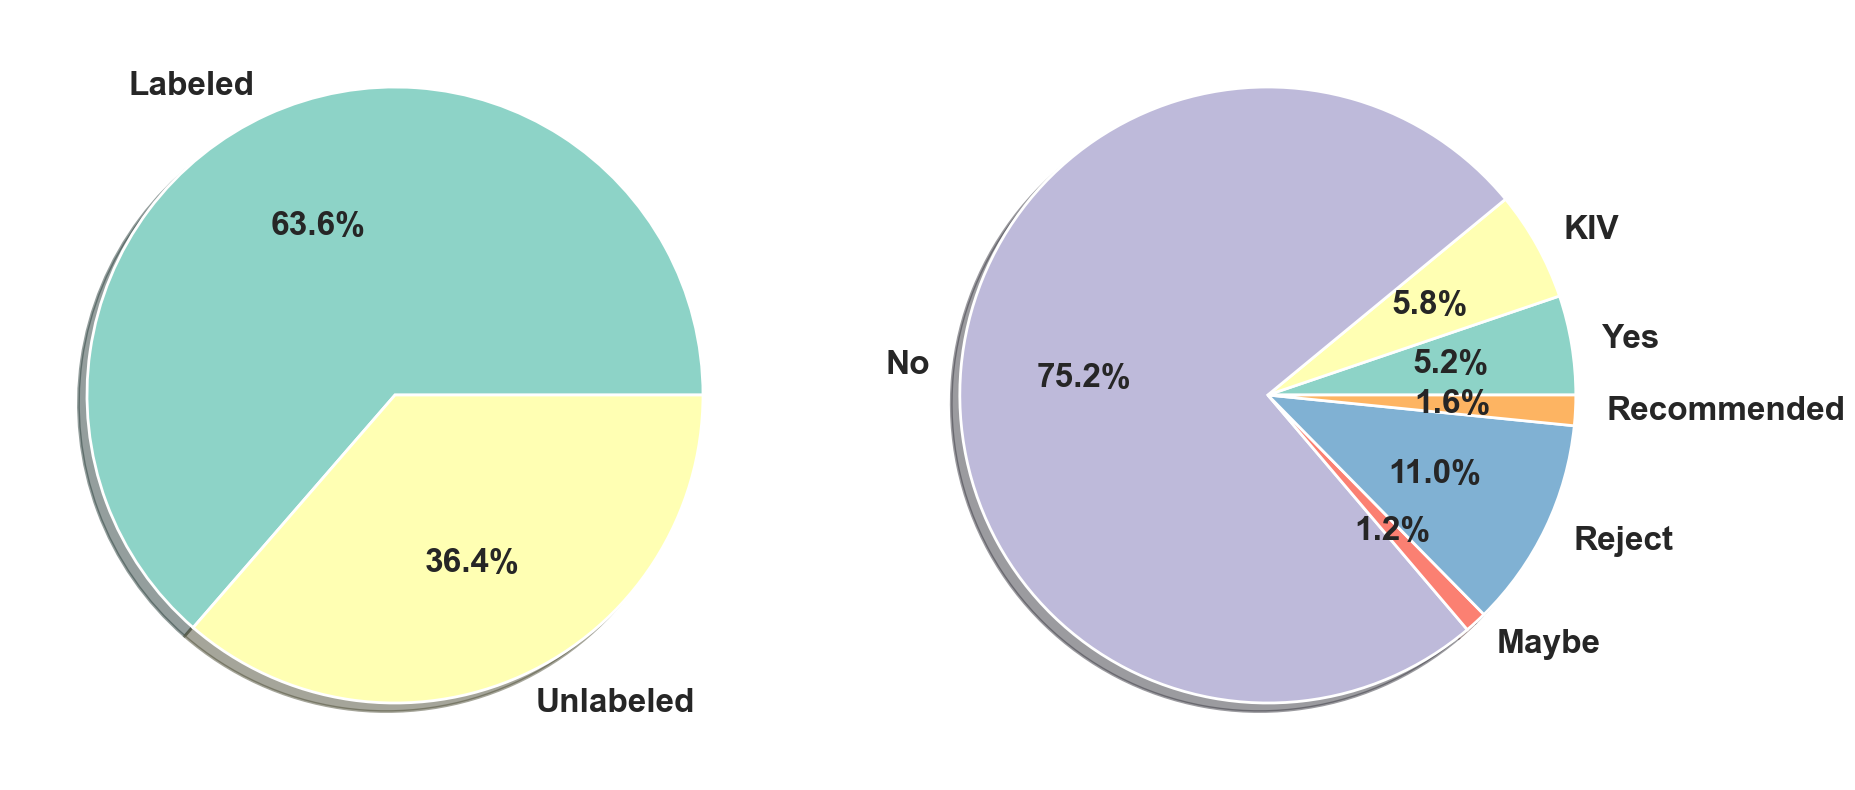

<module 'matplotlib.pyplot' from '/opt/homebrew/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

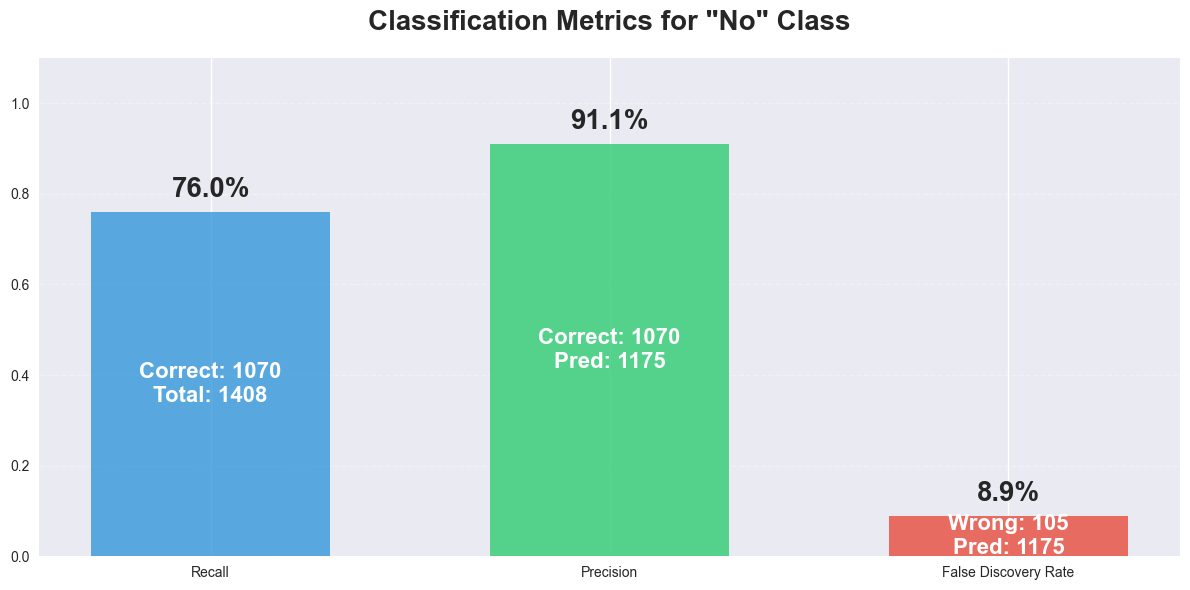

In [1]:
# Load the json data from ../data/data.json and see how many entries there are
from utils import *
import json 

# Read raw data
with open("../data/temasek_grant_data.json") as f:
    raw_data = json.load(f)
    print(len(raw_data))
    
    
data = filter_data_with_label(raw_data, label_key, yes_label_list + no_label_list + neutral_label_list)
process_data(data, "../data/processed_data.json")

labeled_ratio = len(data) / len(raw_data)

label_counts = get_unique_value_count(data, label_key)
positive_comment_counts = get_unique_value_count(data, comment_key, label_key, yes_label_list)
negative_comment_counts = get_unique_value_count(data, comment_key, label_key, no_label_list)

plot_pie_chart(labeled_ratio, label_counts)

metric_dict = calculate_metrics(data, predict_key, label_key)
plot_metrics(metric_dict)

Could not load vllm class, check CUDA support and GPU RAM size


Processing batch of 76 queries: 100%|██████████| 76/76 [00:30<00:00,  2.53it/s]


 :: Total time elapsed: 30.09s, 76 errors


Processing batch of 56 queries: 100%|██████████| 56/56 [00:03<00:00, 14.15it/s]


 :: Total time elapsed: 65.03s, 809 errors


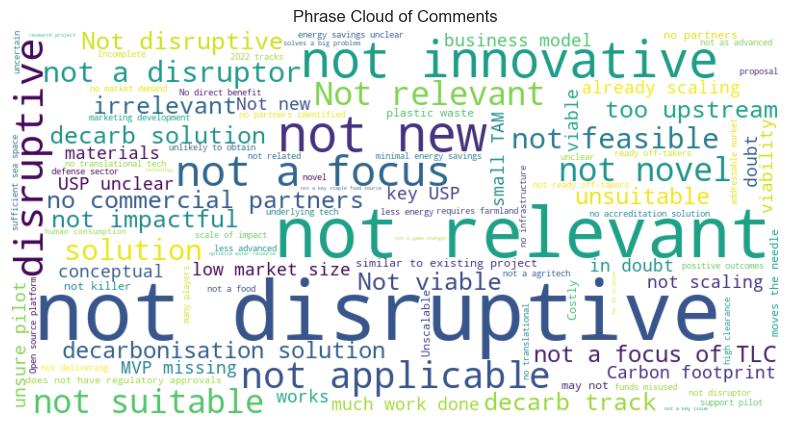

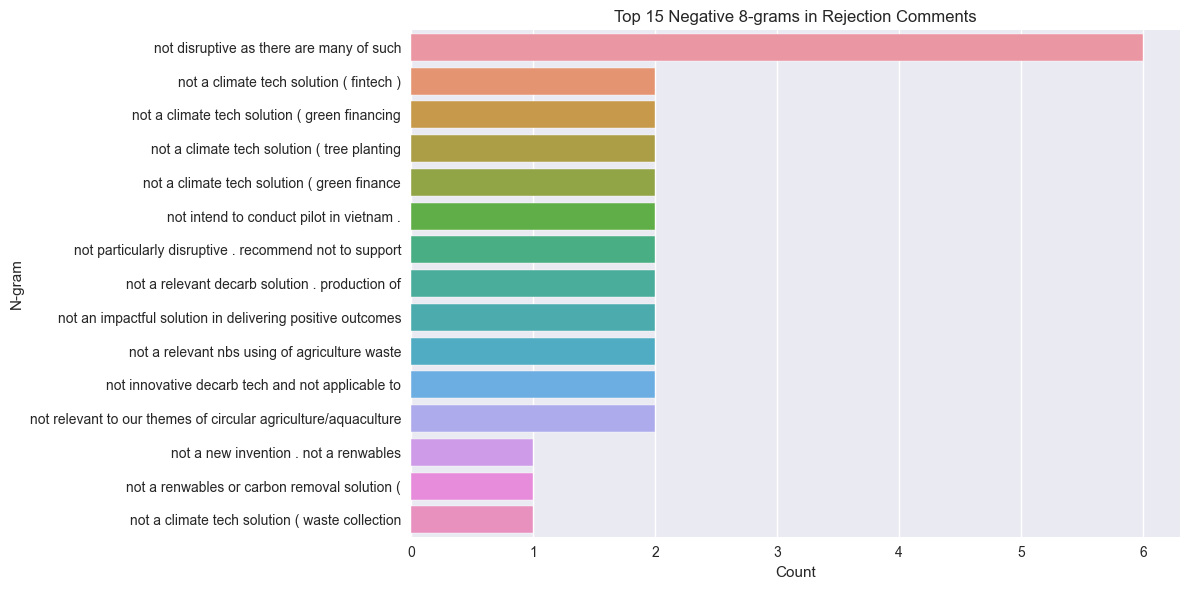

In [13]:
# LLM based key-word extraction
import sys
sys.path.append("../eoh/")
from methods.llm import get_async_vllm_endpoint, get_async_vllm_endpoint_
from methods.meta_prompt import extract_json_from_text
import os 

# Unlimited LLM endpoints
endpoint_id = "vllm-8sz1f7zg7oy0ui"
api_key = "rpa_EPOJED42G59S80Y6SKMCOI330EQU4JPPMKV2UD2W7j0uku"
get_endpoint_response = get_async_vllm_endpoint_(endpoint_id, api_key)

# Key-word extraction powered by LLM
positive_keywords = keyword_extraction_with_llm(positive_comment_counts, False, get_endpoint_response, extract_json_from_text)
negative_keywords = keyword_extraction_with_llm(negative_comment_counts, True, get_endpoint_response, extract_json_from_text)

# Plot key-words cloud 
plot_phrases(positive_keywords)
plot_phrases(negative_keywords)

# N-gram insight plots | Comments on rejection is more duplicated than acceptance
n = 8
get_ngram_plots(negative_comment_counts, n, neg_filter=True, top_k = 15)

In [1]:
from optm.soft_prompt import *

model, tokenizer = load_hf_model("Qwen/Qwen2.5-0.5B-Instruct") # load model & tokenizer

tf_dataset = ClsCommentDataset(load_tf_data, tokenizer, train=True)

# initializing soft-prompt model 
model_with_soft_prompt = SoftPromptLLM(model, tokenizer, 3, initialize_from_vocab=True)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
# Usage
num_epochs = 5
learning_rate = 1e-3
train_dataloader = DataLoader(tf_dataset, batch_size=8, shuffle=True)

trained_model = train_soft_prompt(
    model_with_soft_prompt,
    train_dataloader,
    num_epochs=num_epochs,
    learning_rate=learning_rate
)

Epoch 1/5:  72%|███████▏  | 118/164 [03:36<01:31,  2.00s/it]

In [ ]:
# need some metric to evaluate the performance of the trained model -- cutom loss function

# debugging on the nan value error within CUDA environment ... (?)
